# 情報活用講座：　ケモインフォマテックス編　
# 第５回：　ケモインフォマティックス手法によるプロピレンオキシド製造用触媒候補探索


## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第９章第二節　プロジェクトの例/ 解析例１：触媒データを使った複数モデルの適用

## データセット
journal_data.csvはプロピレンの酸素酸化によるプロピレンオキシド製造用触媒に関する特許から、反応温度が200℃以上で担体がCaCO3である触媒データを収集したデータセットです[1] 。このデータセットは、船津らによる『ケモインフォマティックス手法による新規触媒候補の提案』で使用されたもので、触媒組成、反応条件、およびそのときの触媒性能に関する75件のデータがまとめられています。


[1] 植村 圭祐、荒川 正幹、船津 公人　"ケモインフォマティックス手法による新規触媒候補の提案", Journal of Computer Aided Chemistry Vol.7(2006) 、https://www.jstage.jst.go.jp/article/jcac/7/0/7_0_69/_pdf/-char/ja

【触媒組成】  
重量比は担体を含めた触媒全体に対する重量比であるため、100%に満たない残りの部分は担体などになります。
1. Agの重量比[wt %]
1. Kの重量比[wt %]
1. Moの重量比[wt %]
1. Wの重量比[wt %]
1. Reの重量比[wt %]
1. Auの重量比[wt %]
1. Clの重量比[wt %]
1. Mgの重量比[wt %]
1. Feの重量比[wt %]

【反応条件】
1. Temp: 温度　[℃]
1. P:  圧力　[psig]　　         注１
1. GHSV: 空間速度 [hr-1]        注２
1. C3: 原料中のプロピレンの割合[mol %]
1. O2: 酸素の割合[mol %]
1. NOx: 窒素酸化物の割合[mol %]
1. EtCl: 塩化エチルの割合[mol %]
1. CO2: 二酸化炭素の割合[mol %]

注１：psigは圧力の単位で、1 psigはSI単位系では6894.757 Paです。
注２：空間速度(GHSV: gas hourly space velocity)とは原料の体積流量を触媒層体積で割ったものです。

【前処理の有無】  
触媒前処理は、窒素酸化物（pNOx）、塩化エチル（pEtCl）、二酸化炭素（pCO2）のそれぞれを用いて触媒の前処理を行った場合を1、前処理を行わなかった場合を0とした変数です。
1. pNOx：　窒素酸化物を用いた触媒の前処理の有無
1. pEtCl：　塩化エチルを用いた触媒の前処理の有無
1. pCO2：　二酸化炭素を用いた触媒の前処理の有無

【反応の結果】
1. Conv: プロピレンの転化率[%]
1. Sel:  プロピレンオキシドの選択率[%]
1. yield: 収率[%]


[1]の論文では性能の高い触媒の組成を求めるため、説明変数には触媒組成、反応条件、触媒前処理の有無を用い、転化率と選択率をそれぞれ目的変数として、説明変数と目的変数の間でPLS法による回帰分析が行われています。


## 目標
Pymatgenを使った記述子算出と網羅的なモデル学習を行います。
* 記述子として元々のデータに含まれていたセット`ORIGINAL`とそれらに元素ごとの物性値を存在比で重み付けしたセット`VARIABLE`とに分けて行います。
* 予測モデルにはPLSのほかにランダムフォレストを使用し、3変数をまとめて予測する多変量予測モデルを作ります。

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!pip install pymatgen
!git clone https://github.com/ARIM-Training/Training_python_4.git
%cd Training_python_4

## 1.分子構造データの読み込み 
### ライブラリのインポート

In [1]:
#データ構造化ライブラリ
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#機械学習のライブラリ
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

#警告を無視
from warnings import filterwarnings
filterwarnings('ignore')

### サンプルファイルの読み込み
「data/catalyst」フォルダーにあるjournal_data.csvをpandasの`read_csv()`メソッドを使いデータフレーム（DataFrame）オブジェクトとして変数dfに格納します。dfは23の特徴量からなる75化合物のデータ行列となっていることが確かめられます。

In [2]:
df = pd.read_csv('./data/catalyst/journal_data.csv',index_col=0)
df

,Ag,K,Mo,W,Re,Au,Cl,Mg,Fe,Temp,...,O2,NOx,EtCl,CO2,pNOx,pEtCl,pCO2,Conv,Sel,Yield
label,,,,,,,,,,,,,,,,,,,,,
1,40,2.00,0.00,4.7,0.0,0.0,0.0,0.0,0.0,258,...,5.0,0.0200,0.0050,10.0,0,0,0,12.0,48.0,5.8
2,40,2.00,0.00,4.7,0.0,0.0,0.0,0.0,0.0,258,...,5.0,0.0200,0.0050,5.0,0,0,0,13.0,44.0,5.7
3,50,2.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,260,...,5.0,0.0200,0.0050,0.0,0,0,1,13.0,44.0,5.7
4,50,2.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,260,...,5.0,0.0200,0.0050,0.0,0,0,0,13.0,42.0,5.5
5,40,2.00,0.00,4.7,0.0,0.0,0.0,0.0,0.0,258,...,5.0,0.0200,0.0050,25.0,0,0,0,10.0,54.0,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,25,1.00,0.50,0.0,0.0,4.6,0.0,0.0,0.0,250,...,5.0,0.0000,0.0000,0.0,0,0,0,2.0,50.0,1.0
72,49,0.57,0.49,0.0,0.0,0.0,0.7,0.0,0.0,250,...,8.0,0.0005,0.0005,10.0,0,0,0,1.5,64.0,1.0
73,49,0.57,0.49,0.0,0.0,0.0,0.7,0.0,0.0,250,...,8.0,0.0000,0.0000,10.0,0,0,0,1.5,58.0,0.9


触媒組成を除いた「反応条件」、「前処理の有無」、「反応の結果」を確認します。

In [3]:
df.iloc[:,9:]

,Temp,P,GHSV,C3,O2,NOx,EtCl,CO2,pNOx,pEtCl,pCO2,Conv,Sel,Yield
label,,,,,,,,,,,,,,
1,258,40,1200,10.0,5.0,0.0200,0.0050,10.0,0,0,0,12.0,48.0,5.8
2,258,40,1200,10.0,5.0,0.0200,0.0050,5.0,0,0,0,13.0,44.0,5.7
3,260,40,1200,10.0,5.0,0.0200,0.0050,0.0,0,0,1,13.0,44.0,5.7
4,260,40,1200,10.0,5.0,0.0200,0.0050,0.0,0,0,0,13.0,42.0,5.5
5,258,40,1200,10.0,5.0,0.0200,0.0050,25.0,0,0,0,10.0,54.0,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,250,30,1200,10.0,5.0,0.0000,0.0000,0.0,0,0,0,2.0,50.0,1.0
72,250,30,2400,8.0,8.0,0.0005,0.0005,10.0,0,0,0,1.5,64.0,1.0
73,250,30,2400,8.0,8.0,0.0000,0.0000,10.0,0,0,0,1.5,58.0,0.9


後半の機械学習では触媒組成も機械学習の説明変数に用いてモデル化します。そのとき圧力のラベル「P」は触媒組成としてリン（P）と誤って読まれてしまうおそれがあります。このとから、ここでは圧力Pを「Pressure」と変数名を変更します。変数名の変更はpandasの`remane()`メソッドを使います。

In [4]:
df = df.rename(columns={'P': 'Pressure'})
df.iloc[:,9:]

,Temp,Pressure,GHSV,C3,O2,NOx,EtCl,CO2,pNOx,pEtCl,pCO2,Conv,Sel,Yield
label,,,,,,,,,,,,,,
1,258,40,1200,10.0,5.0,0.0200,0.0050,10.0,0,0,0,12.0,48.0,5.8
2,258,40,1200,10.0,5.0,0.0200,0.0050,5.0,0,0,0,13.0,44.0,5.7
3,260,40,1200,10.0,5.0,0.0200,0.0050,0.0,0,0,1,13.0,44.0,5.7
4,260,40,1200,10.0,5.0,0.0200,0.0050,0.0,0,0,0,13.0,42.0,5.5
5,258,40,1200,10.0,5.0,0.0200,0.0050,25.0,0,0,0,10.0,54.0,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,250,30,1200,10.0,5.0,0.0000,0.0000,0.0,0,0,0,2.0,50.0,1.0
72,250,30,2400,8.0,8.0,0.0005,0.0005,10.0,0,0,0,1.5,64.0,1.0
73,250,30,2400,8.0,8.0,0.0000,0.0000,10.0,0,0,0,1.5,58.0,0.9


### 可視化

[1]の論文にあるように、プロピレンオキシド製造用触媒の転化率と選択率の関係について可視化してみることにしましょう。


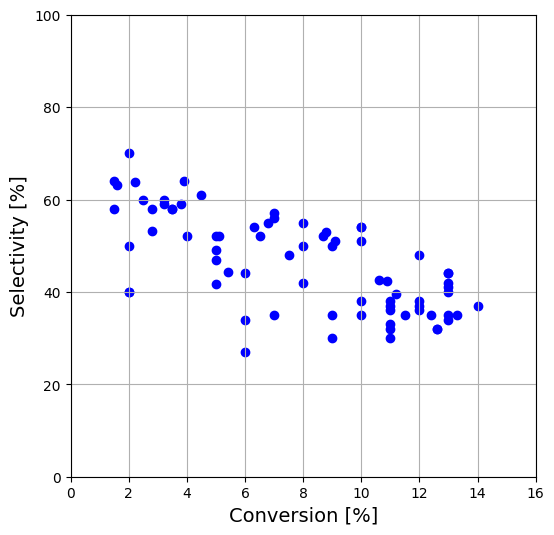

In [5]:
#転化率と選択率の関係

fig = plt.figure(figsize=(6,6))

plt.scatter(df['Conv'], df['Sel'], color='blue')

# 軸ラベル
plt.xlabel("Conversion [%]", fontsize =14)
plt.ylabel("Selectivity [%]", fontsize =14)

# 軸範囲
plt.xlim(0,16)
plt.ylim(0,100)
plt.grid()

plt.show()

75件の触媒データについて転化率と選択率の関係をプロットしたものから、転化率が高いと選択率が低く、選択率が高いと転化率が低いというトレードオフの傾向があることがうかがわれます。

### 特徴量の相関
散布図や相関係数のクロス表から、反応条件等と転化率、選択率、または収率との関係をみてみることにしましょう。

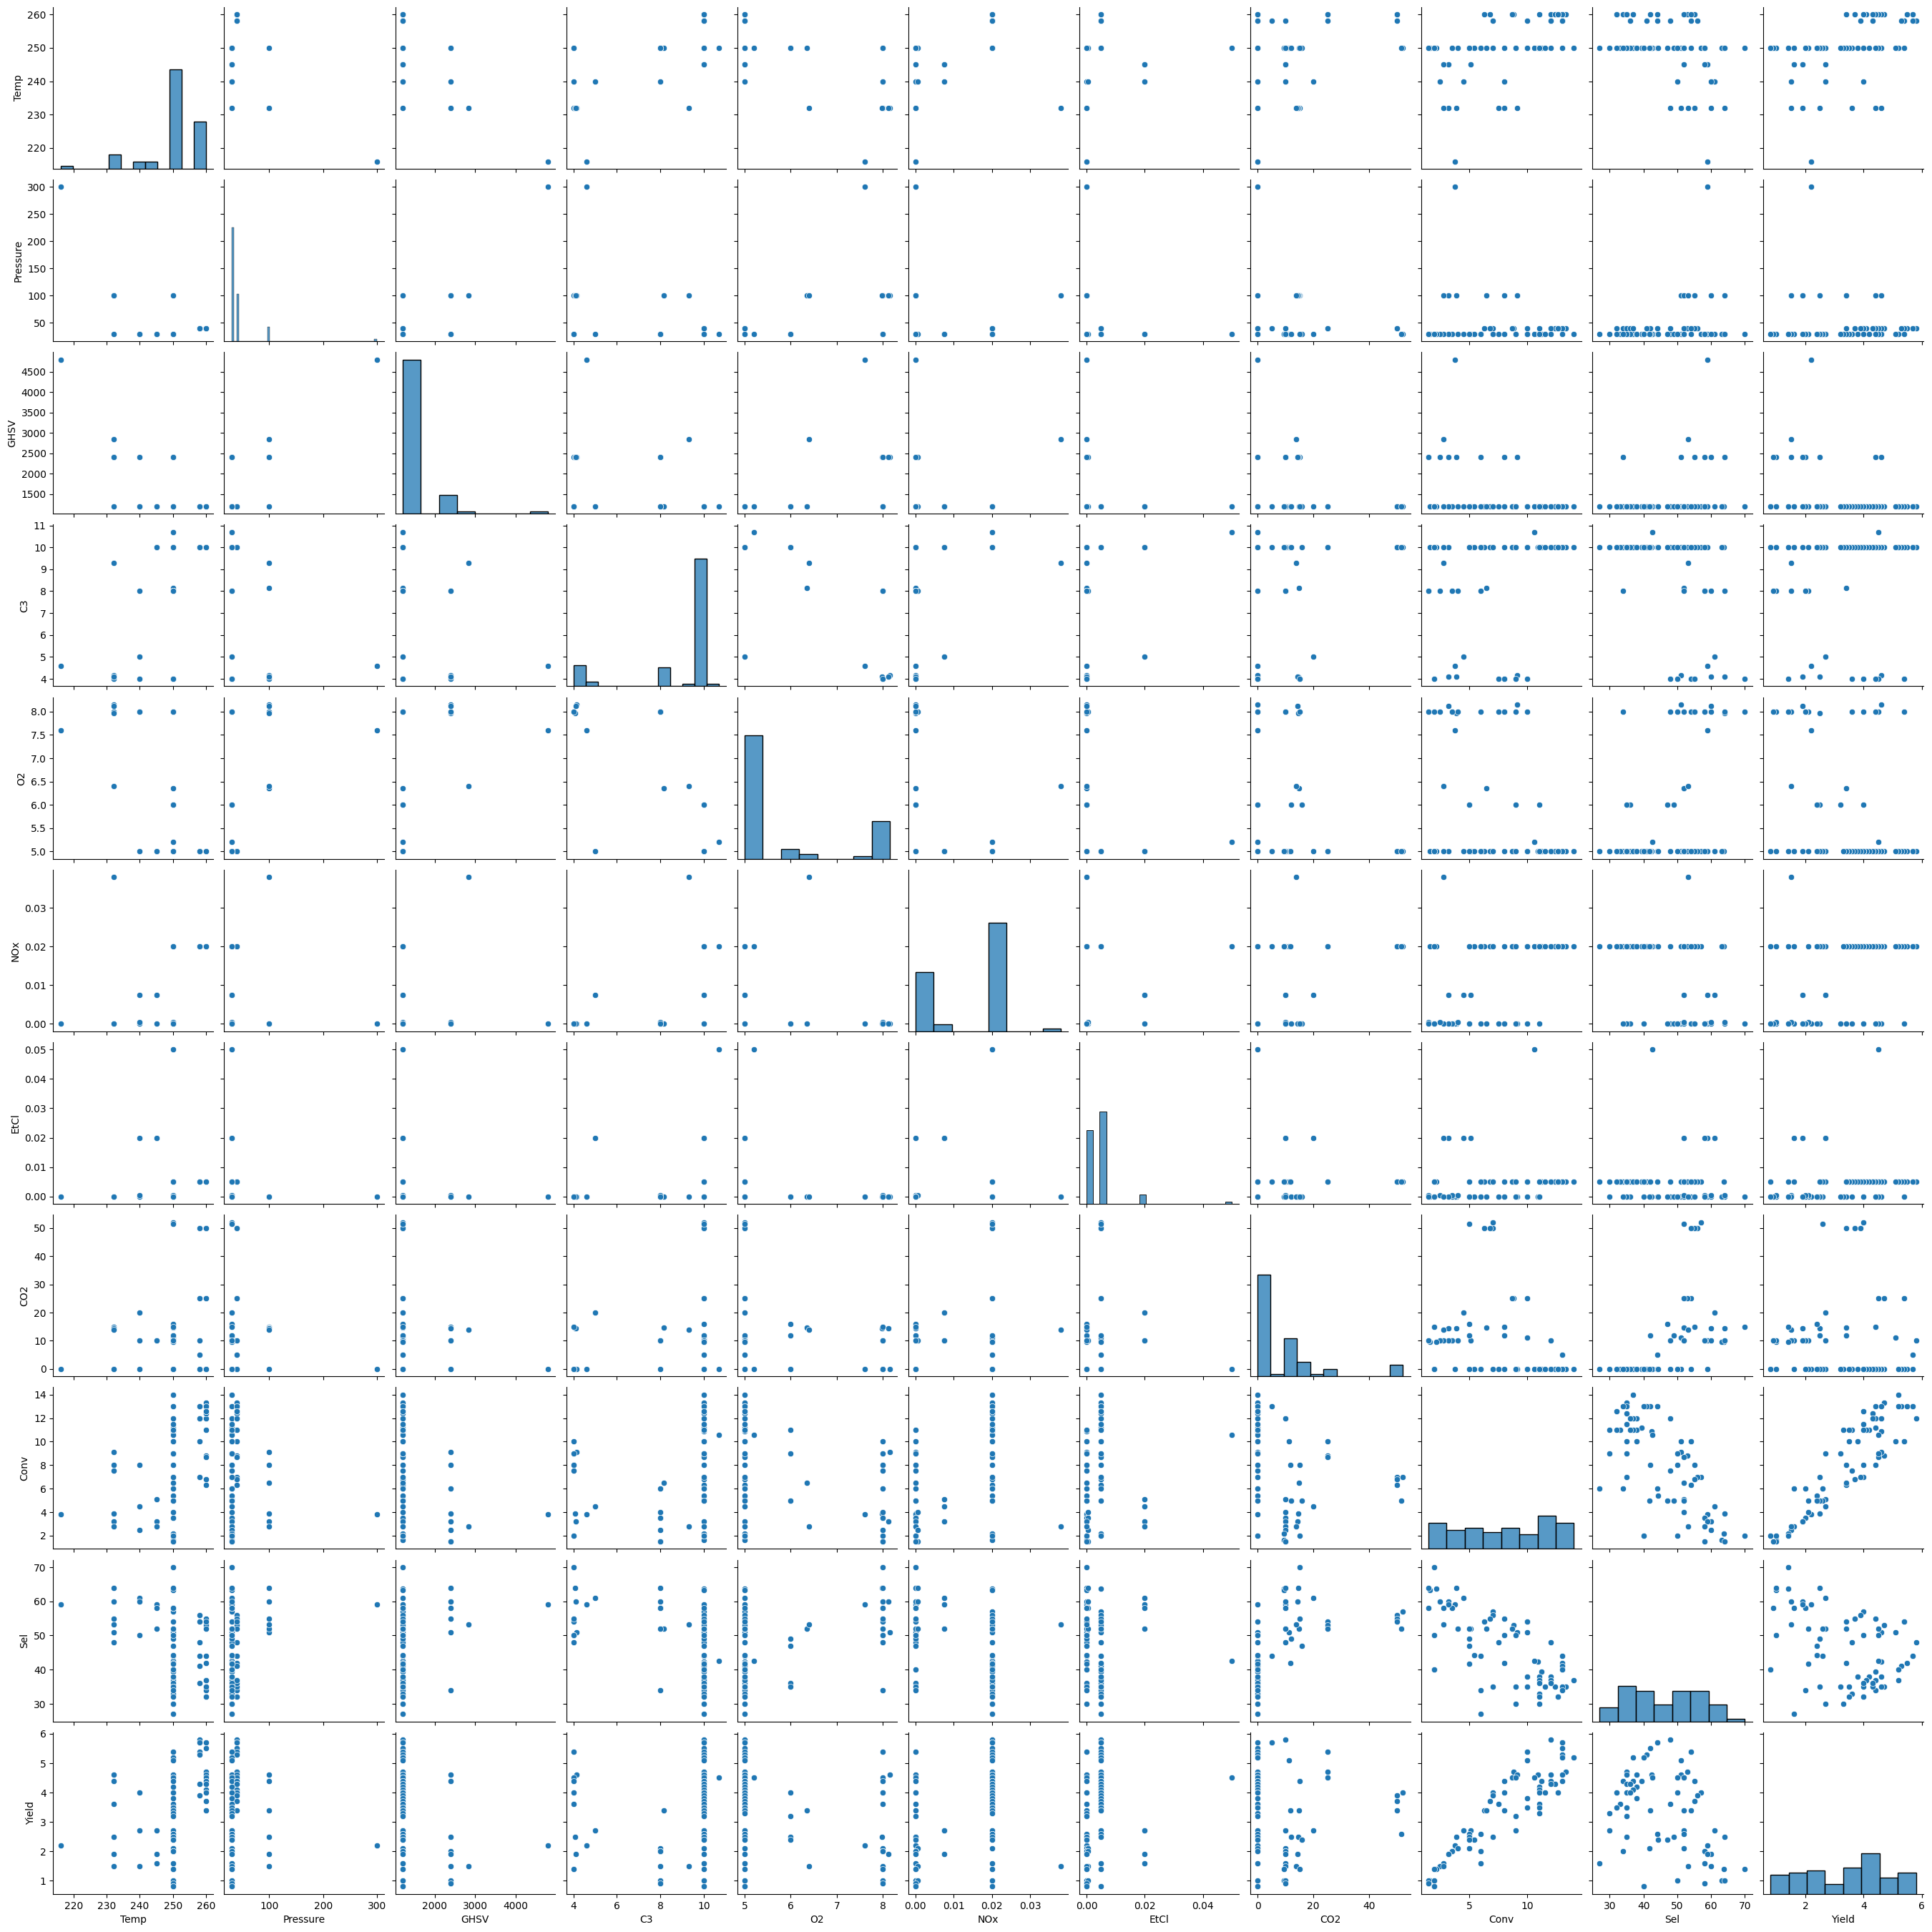

In [6]:
REACTION =['Temp','Pressure','GHSV','C3','O2','NOx','EtCl','CO2','Conv','Sel','Yield']
sns.pairplot(df,vars=REACTION)
plt.show()

In [7]:
#　相関係数
corr = df.corr()
corr

,Ag,K,Mo,W,Re,Au,Cl,Mg,Fe,Temp,...,O2,NOx,EtCl,CO2,pNOx,pEtCl,pCO2,Conv,Sel,Yield
Ag,1.000000,-0.127855,0.576425,-0.267402,0.216583,-0.659628,0.367046,-0.208579,-0.211473,-0.266129,...,0.362879,-0.323077,0.062580,0.025616,0.234352,0.322766,0.021689,-0.112416,0.345941,-0.016667
K,-0.127855,1.000000,-0.298895,0.215580,0.025928,-0.131759,-0.587711,0.130835,0.135334,0.147294,...,-0.478213,0.393733,0.121601,-0.045136,0.022373,0.186105,0.197658,0.432814,-0.315802,0.421268
Mo,0.576425,-0.298895,1.000000,-0.312710,0.031410,-0.096273,0.284750,-0.192877,-0.199682,-0.373999,...,0.450447,-0.467726,-0.053925,-0.148092,0.201128,0.406573,-0.033382,-0.321386,0.376598,-0.235827
W,-0.267402,0.215580,-0.312710,1.000000,-0.131212,-0.091105,-0.187312,-0.090871,-0.094077,0.382869,...,-0.225869,0.260875,0.031528,0.284295,-0.078350,-0.203659,0.030002,0.275927,0.022114,0.396191
Re,0.216583,0.025928,0.031410,-0.131212,1.000000,-0.081139,-0.051294,-0.080931,-0.083786,-0.000544,...,-0.212228,0.241712,-0.104374,0.025608,-0.069779,0.251345,-0.109679,-0.109702,0.134109,-0.076401
Au,-0.659628,-0.131759,-0.096273,-0.091105,-0.081139,1.000000,-0.115831,-0.056193,-0.058176,-0.000378,...,-0.147358,-0.075167,-0.105810,-0.145247,-0.048450,-0.133383,-0.076154,-0.303620,-0.061986,-0.353101
Cl,0.367046,-0.587711,0.284750,-0.187312,-0.051294,-0.115831,1.000000,-0.115533,-0.119609,-0.083661,...,0.496064,-0.498990,-0.274672,-0.044460,-0.058108,-0.064750,-0.156573,-0.299507,0.127328,-0.341041
Mg,-0.208579,0.130835,-0.192877,-0.090871,-0.080931,-0.056193,-0.115533,1.000000,0.699028,-0.000377,...,-0.146979,0.167398,0.021719,-0.144873,-0.048326,-0.133040,-0.075959,0.183084,-0.207314,0.112947
Fe,-0.211473,0.135334,-0.199682,-0.094077,-0.083786,-0.058176,-0.119609,0.699028,1.000000,-0.000390,...,-0.152164,0.173304,0.022485,-0.149984,-0.050030,-0.137733,-0.078638,0.165995,-0.266029,0.057961
Temp,-0.266129,0.147294,-0.373999,0.382869,-0.000544,-0.000378,-0.083661,-0.000377,-0.000390,1.000000,...,-0.575634,0.474022,0.098288,0.086452,-0.081581,-0.567590,0.163698,0.474993,-0.395705,0.388083


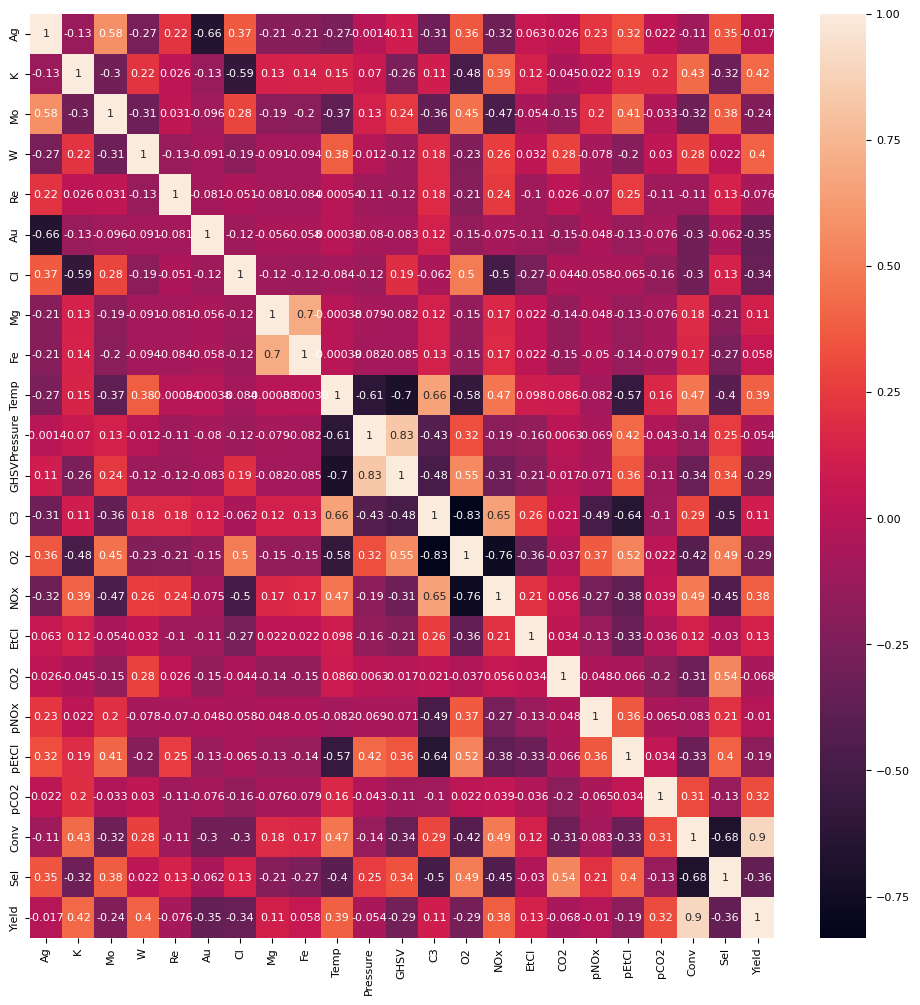

In [8]:
#相関係数をヒートマップ化する
fig = plt.figure(figsize=(12,12))
plt.rcParams["font.size"] = 8

sns.heatmap(corr, annot=True)
plt.show()

## ２.機械学習モデリング　（底本P115）
### 部分的最小二乗回帰(Partial Least Squares）

部分的最小二乗回帰（Partial Least Squares、PLS）は、回帰分析の手法の一つであり、複数の説明変数（特徴量）と目的変数（ターゲット）の間の関係性を見つけるために使用されます。PLSは、説明変数と目的変数の間の相関を最大化するように潜在変数を見つけることに焦点を当てています。

PLSは、以下の主な手順で実行されます。

1. データの前処理: 説明変数と目的変数のデータを準備します。データのスケーリングや欠損値の処理など、必要な前処理を行います。

2. 潜在変数の選択: PLSでは、説明変数と目的変数の間の相関を最大化する潜在変数を見つけるために、反復的な手法が使用されます。最初の潜在変数は、説明変数と目的変数の間の最大の相関を持つ単変量回帰ベクトルとして定義されます。次に、2番目の潜在変数は、目的変数の残差と説明変数の残差の間の相関を最大化するように計算されます。このプロセスは、指定した潜在変数の数（または他の終了条件）に達するまで繰り返されます。

3. 回帰モデルの構築: 選択された潜在変数を使用して、部分的最小二乗回帰モデルを構築します。このモデルは、説明変数と目的変数の間の線形関係を表現します。

PLSは、次元の高いデータセットや多重共線性のあるデータセットで特に有用です。また、変数の選択や次元削減の手法としても活用されることがあります。

論文[1]では説明変数には触媒組成、反応条件、触媒前処理の有無を用い、転化率と選択率をそれぞれ目的変数として、説明変数と目的変数の間でPLS法による回帰分析が行われています。それをscilit-learnで再現してみましょう。

### データセットの分割（Data set splitting）

In [9]:
x = df.iloc[0:, 0:20] # 説明変数行列
y = df.iloc[0:, 20:22]   # 目的変数

X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2,   # CV用データ分割
                                                    random_state=42
                                                    )  

### 機械学習モデルの構築

In [10]:
# PLSモデル
from sklearn.cross_decomposition import PLSRegression

#予測器の作成
model =  PLSRegression()

### 転化率にかかるPLS

In [11]:
model.fit(X_train, y_train['Conv'])

#予測値
y_pred_train= model.predict(X_train)
y_pred_test = model.predict(X_test)

# 決定係数
r2_train = r2_score(y_train['Conv'], y_pred_train)
r2_test = r2_score(y_test['Conv'], y_pred_test)

print('r^2 訓練データ: {}'.format(r2_train))
print('r^2 テストデータ: {}'.format(r2_test))

r^2 訓練データ: 0.6903020909544593
r^2 テストデータ: 0.3127917834318149


訓練データのR2は69%、テストデータでは31%であり、PLSそのものではモデル構築がほとんどできていないことがわかります。
Observed-Calc図で確認をしてみましょう。

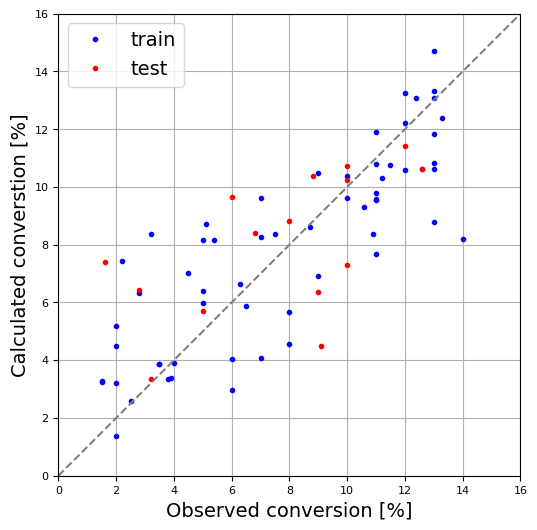

In [12]:
fig = plt.figure(figsize=(6,6))

plt.plot(y_train['Conv'], y_pred_train, '.', c = 'blue', label ='train')
plt.plot(y_test['Conv'], y_pred_test, '.', c = 'red', label ='test')

plt.plot([0, 100], [0, 100], linestyle='--', color ='gray')  # 対角線のプロット

plt.axis('square')
plt.xlabel('Observed conversion [%]',fontsize = 14)
plt.ylabel('Calculated converstion [%]',fontsize = 14)

plt.xlim(0,16)
plt.ylim(0,16)
plt.legend(fontsize = 14)
plt.grid()

#plt.savefig('../results/9.3-yyplot-rdkitpls.jpg')
plt.show()

### 選択率にかかるPLS

In [13]:
model.fit(X_train, y_train['Sel'])

#予測値
y_pred_train= model.predict(X_train)
y_pred_test = model.predict(X_test)

#決定係数
print('r^2 訓練データ: {}'.format(r2_score(y_train['Sel'], y_pred_train)))
print('r^2 テストデータ: {}'.format(r2_score(y_test['Sel'], y_pred_test)))

r^2 訓練データ: 0.7440475818186071
r^2 テストデータ: 0.5636813837355248


選択率については、訓練データのR2は74%、テストデータでは56%と転化率よりかは向上していますが、同じくPLSそのものではモデル構築がほとんどできていないことがわかります。それをObserved-Calc図で確認をしてみましょう。

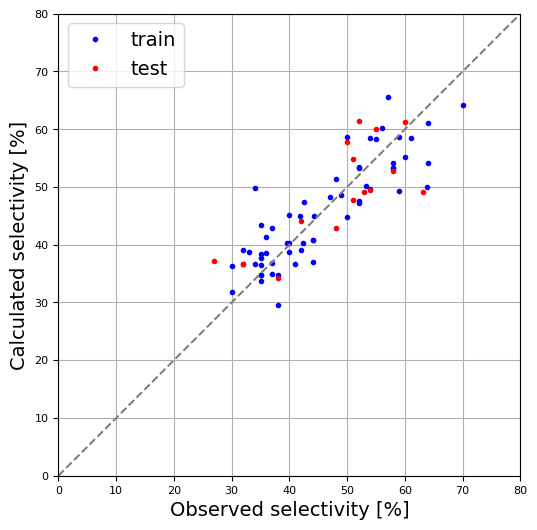

In [14]:
fig = plt.figure(figsize=(6,6))

plt.plot(y_train['Sel'], y_pred_train, '.', c = 'blue', label ='train')
plt.plot(y_test['Sel'], y_pred_test, '.', c = 'red', label ='test')

plt.plot([0, 100], [0, 100], linestyle='--', color ='gray')  # 対角線のプロット

plt.axis('square')
plt.xlabel('Observed selectivity [%]',fontsize = 14)
plt.ylabel('Calculated selectivity [%]',fontsize = 14)

plt.xlim(0,80)
plt.ylim(0,80)

plt.legend(fontsize = 14)
plt.grid()

#plt.savefig('../results/9.3-yyplot-rdkitpls.jpg')
plt.show()

PLS法により構築した転化率のモデルと選択率のモデルのいずれも予測性は不十分です。
そこで説明変数を増しモデルの精度を高める検討を進めることにします。ここではpymatgenライブラリにある金属・無機材料を表現する記述子を使いモデルの精度を高められるかについて検討することにします。pymatgenで金属・無機材料を表現する記述子の中で、ここでは金属の分子軌道エネルギーを取り込み、また幾つかの物性にかかる指標を含めたデータ空間を検討します。

### pymatgenの活用：分子軌道エネルギーの取得
「pymatgen.core.periodic_table」モジュールは、Pymatgen（Python Materials Genomics）ライブラリの一部で、周期表に関連する要素の情報を提供します。モジュールには、Element、Species（Element + oxidation state）、PeriodicTable を表すクラスが含まれています。

(https://pymatgen.org/pymatgen.core.periodic_table.html)

このモジュールを使用することで、元素の原子番号、元素記号、元素名、原子量、電子配置、およびその他の化学的性質などの情報を取得することができます。

以下に、いくつかのモジュールの主要なクラスと機能を示します。

* `Element` クラス: このクラスは、個々の化学元素を表します。各元素には一意の原子番号、元素記号、および元素名があります。また、元素に関連するプロパティ（原子量、電子配置など）も提供されます。

* `Species` クラス: このクラスは、Element の拡張で、酸化状態やその他のオプションの性質を持ちます。Speciesに関連する性質は、計算値ではなく「理想化」された値である必要があります。例えば、高スピンFe2+は+5という理想化されたスピンが割り当てられますが、実際のFe2+ サイトは+4.5というMAGMOM(Magnetic Moment) が計算されます。


In [15]:
from pymatgen.core.periodic_table import Element, Species

In [16]:
dir(Element)

['Ac',
 'Ag',
 'Al',
 'Am',
 'Ar',
 'As',
 'At',
 'Au',
 'B',
 'Ba',
 'Be',
 'Bh',
 'Bi',
 'Bk',
 'Br',
 'C',
 'Ca',
 'Cd',
 'Ce',
 'Cf',
 'Cl',
 'Cm',
 'Cn',
 'Co',
 'Cr',
 'Cs',
 'Cu',
 'Db',
 'Ds',
 'Dy',
 'Er',
 'Es',
 'Eu',
 'F',
 'Fe',
 'Fl',
 'Fm',
 'Fr',
 'Ga',
 'Gd',
 'Ge',
 'H',
 'He',
 'Hf',
 'Hg',
 'Ho',
 'Hs',
 'I',
 'In',
 'Ir',
 'K',
 'Kr',
 'La',
 'Li',
 'Lr',
 'Lu',
 'Lv',
 'Mc',
 'Md',
 'Mg',
 'Mn',
 'Mo',
 'Mt',
 'N',
 'Na',
 'Nb',
 'Nd',
 'Ne',
 'Nh',
 'Ni',
 'No',
 'Np',
 'O',
 'Og',
 'Os',
 'P',
 'Pa',
 'Pb',
 'Pd',
 'Pm',
 'Po',
 'Pr',
 'Pt',
 'Pu',
 'Ra',
 'Rb',
 'Re',
 'Rf',
 'Rg',
 'Rh',
 'Rn',
 'Ru',
 'S',
 'Sb',
 'Sc',
 'Se',
 'Sg',
 'Si',
 'Sm',
 'Sn',
 'Sr',
 'Ta',
 'Tb',
 'Tc',
 'Te',
 'Th',
 'Ti',
 'Tl',
 'Tm',
 'Ts',
 'U',
 'V',
 'W',
 'Xe',
 'Y',
 'Yb',
 'Zn',
 'Zr',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [17]:
#元素数の確認
elem_names = [e for e in dir(Element) if not e.startswith('_')] 
len(elem_names)

118

In [18]:
dir(Species)

['REDIRECT',
 'STRING_MODE',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get_validators__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__modify_schema__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'as_dict',
 'element',
 'from_dict',
 'from_string',
 'get_crystal_field_spin',
 'get_nmr_quadrupole_moment',
 'get_shannon_radius',
 'ionic_radius',
 'oxi_state',
 'supported_properties',
 'to_html_string',
 'to_json',
 'to_latex_string',
 'to_pretty_string',
 'to_unicode_string',
 'unsafe_hash',
 'validate_monty']

元素記号の各種の電子状態などの数値は、`Element`クラスに元素記号を割り当てることでオブジェクト化することができます。
* 分子軌道エネルギーはそのオブジェクトから`atomic_orbitals`メソッドより取り出せます。
* `ionization_energies`メソッドを適用するとイオン化エネルギーを取得できます。

In [19]:
element_name = 'Al'
elem = Element(element_name)
elem

Element Al

In [20]:
# Alの分子軌道エネルギーの出力
elem.atomic_orbitals

{'1s': -55.156044,
 '2p': -2.564018,
 '2s': -3.934827,
 '3p': -0.102545,
 '3s': -0.286883}

In [21]:
# Alのイオン化エネルギーの出力
elem.ionization_energies

[5.985769,
 18.82855,
 28.447642,
 119.9924,
 153.8252,
 190.49,
 241.76,
 284.64,
 330.21,
 398.65,
 442.005,
 2085.97702,
 2304.14007]

118のエントリーされている元素に対して、分子軌道エネルギーが取得できるもののみを取り出します。ここでは軌道エネルギーがない場合にはエラーとなるため、try-except文で空になっている元素についてはスキップさせる方法としています。（底本でのコードとは異なります）

In [22]:
dictionary = []
elements = []

for name in elem_names:
    
    elem = Element(name)
    
    try:
        dictionary.append(elem.atomic_orbitals)
        elements.append(name)
        
    except:
        pass

In [23]:
len(dictionary)

103

実際に分子軌道エネルギーの値が含まれている元素は103つであることが確認されました。次に軌道ごとのエネルギー値を一覧化させます。pandasのデータフレーム形式としてdf_orbitsというオブジェクトで格納します。

In [24]:
df_orbits = pd.DataFrame([c if c is not None else {} for c in dictionary], index = elements)
df_orbits

,1s,2p,2s,3d,3p,3s,4d,4f,4p,4s,5d,5p,5s,6d,6p,6s,7s,5f
Ac,-3443.110367,-572.762700,-592.622878,-119.541743,-137.654394,-147.320716,-23.570610,-12.278225,-31.761846,-36.158260,-3.222752,-6.065110,-7.713078,-0.137786,-0.744524,-1.196980,-0.126551,NaN
Ag,-900.324578,-120.913351,-129.859807,-13.367803,-20.067630,-23.678437,-0.298706,NaN,-2.086602,-3.223090,NaN,NaN,-0.157407,NaN,NaN,NaN,NaN,NaN
Al,-55.156044,-2.564018,-3.934827,NaN,-0.102545,-0.286883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Am,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ar,-113.800134,-8.443439,-10.794172,NaN,-0.382330,-0.883384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xe,-1208.688993,-172.599583,-183.327495,-24.378230,-32.867042,-37.415454,-2.286666,NaN,-5.063802,-6.678340,NaN,-0.309835,-0.672086,NaN,NaN,NaN,NaN,NaN
Y,-605.631981,-74.803201,-81.789102,-5.671499,-10.399926,-12.992217,-0.108691,NaN,-1.024490,-1.697124,NaN,NaN,-0.150727,NaN,NaN,NaN,NaN,NaN
Yb,-2084.069389,-323.178219,-337.978976,-56.026315,-68.698655,-75.476630,-6.574963,-0.286408,-11.558246,-14.312076,NaN,-0.966137,-1.683886,NaN,NaN,-0.136989,NaN,NaN
Zn,-344.969756,-36.648765,-41.531323,-0.398944,-3.022363,-4.573041,NaN,NaN,NaN,-0.222725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NaN	があるため、ここままではモデルにおける説明変数としては扱えません。そこで`fillna()`メソッドを使いNaNにはゼロ値を埋め込む処理を施します。

In [25]:
df_orbits = pd.DataFrame([c if c is not None else {} for c in dictionary], index = elements).fillna(0)
df_orbits

,1s,2p,2s,3d,3p,3s,4d,4f,4p,4s,5d,5p,5s,6d,6p,6s,7s,5f
Ac,-3443.110367,-572.762700,-592.622878,-119.541743,-137.654394,-147.320716,-23.570610,-12.278225,-31.761846,-36.158260,-3.222752,-6.065110,-7.713078,-0.137786,-0.744524,-1.196980,-0.126551,0.0
Ag,-900.324578,-120.913351,-129.859807,-13.367803,-20.067630,-23.678437,-0.298706,0.000000,-2.086602,-3.223090,0.000000,0.000000,-0.157407,0.000000,0.000000,0.000000,0.000000,0.0
Al,-55.156044,-2.564018,-3.934827,0.000000,-0.102545,-0.286883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Am,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Ar,-113.800134,-8.443439,-10.794172,0.000000,-0.382330,-0.883384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xe,-1208.688993,-172.599583,-183.327495,-24.378230,-32.867042,-37.415454,-2.286666,0.000000,-5.063802,-6.678340,0.000000,-0.309835,-0.672086,0.000000,0.000000,0.000000,0.000000,0.0
Y,-605.631981,-74.803201,-81.789102,-5.671499,-10.399926,-12.992217,-0.108691,0.000000,-1.024490,-1.697124,0.000000,0.000000,-0.150727,0.000000,0.000000,0.000000,0.000000,0.0
Yb,-2084.069389,-323.178219,-337.978976,-56.026315,-68.698655,-75.476630,-6.574963,-0.286408,-11.558246,-14.312076,0.000000,-0.966137,-1.683886,0.000000,0.000000,-0.136989,0.000000,0.0
Zn,-344.969756,-36.648765,-41.531323,-0.398944,-3.022363,-4.573041,0.000000,0.000000,0.000000,-0.222725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


### 記述子計算

journal_data.csvのdfとpymatgen.core.periodic_tableとで一致している元素を調べてみましょう。まずdfのカラム名をみると次のようになっています。'Ag', 'K', 'Mo', 'W', 'Re', 'Au', 'Cl', 'Mg', 'Fe'の9種類が触媒組成に含まれていることがわかります。

In [26]:
df.columns

Index(['Ag', 'K', 'Mo', 'W', 'Re', 'Au', 'Cl', 'Mg', 'Fe', 'Temp', 'Pressure',
       'GHSV', 'C3', 'O2', 'NOx', 'EtCl', 'CO2', 'pNOx', 'pEtCl', 'pCO2',
       'Conv', 'Sel', 'Yield'],
      dtype='object')

この中でpymatgen.core.periodic_tableとで元素が一致しているものを、三項演算子を使って次のようにelements_indesc変数に格納します。格納されるのは'Ag'から'Fe'までの9の元素です。

In [27]:
elements_indesc = [c_ for c_ in df.columns if c_ in elements]
elements_indesc

['Ag', 'K', 'Mo', 'W', 'Re', 'Au', 'Cl', 'Mg', 'Fe']

次にElementクラスの中で沸点、融点、液体範囲、メンデレーエフ番号、モル体積、熱伝導率を説明変数としてとりあげ、モデル構築におけるデータ空間の拡張を試みます。

In [28]:
tuple_vars = ['boiling_point', 'melting_point', 'liquid_range', 'mendeleev_no', 'molar_volume', 'thermal_conductivity']
tuple_vars

['boiling_point',
 'melting_point',
 'liquid_range',
 'mendeleev_no',
 'molar_volume',
 'thermal_conductivity']

再帰的なデータの抽出する方法は幾つかの方法がある中、ここではlambda関数を以下のような入れ子構造（ネスト）で行う方法を示します。多重ネストはコードが複雑になることや解読が難読化するため、進める方法ではありません。

In [29]:
map_from_y_with_x = lambda x,y: list(map(x, y))

X = map_from_y_with_x(lambda elem: map_from_y_with_x(lambda method: getattr(Element(elem), method), list(tuple_vars)), elements_indesc)

【解説】
Pythonのlambda関数、list、およびmapを使用したわかりやすいコードの事例をいくつか示します。

1. リストの各要素を2倍にする例:
```python
numbers = [1, 2, 3, 4, 5]
doubled_numbers = list(map(lambda x: x * 2, numbers))
print(doubled_numbers)  # Output: [2, 4, 6, 8, 10]
```
この例では、lambda関数を使用して各要素を2倍にします。`map`関数を使用してlambda関数をリストの各要素に適用し、結果を新しいリストとして取得します。

2. 文字列のリストから長さが3以下の文字列をフィルタリングする例:
```python
words = ["apple", "banana", "cat", "dog", "elephant"]
short_words = list(filter(lambda x: len(x) <= 3, words))
print(short_words)  # Output: ["cat", "dog"]
```
この例では、lambda関数を使用して長さが3以下の文字列をフィルタリングします。`filter`関数を使用してlambda関数をリストの各要素に適用し、条件に一致する要素だけを取得します。

3. リストの各要素を大文字に変換する例:
```python
names = ["alice", "bob", "charlie"]
uppercased_names = list(map(lambda x: x.upper(), names))
print(uppercased_names)  # Output: ["ALICE", "BOB", "CHARLIE"]
```
この例では、lambda関数を使用して各要素を大文字に変換します。`map`関数を使用してlambda関数をリストの各要素に適用し、結果を新しいリストとして取得します。

これらの例は、lambda関数を使用してリストの要素に変換やフィルタリングを適用する際の一般的なパターンを示しています。これらの関数を組み合わせることで、さまざまなデータ操作を簡潔に実現することができます。

In [30]:
X

[[2435.0, 1234.93, 1200.07, 71.0, 10.27, 430.0],
 [1032.0, 336.53, 695.47, 10.0, 45.94, 100.0],
 [4912.0, 2896.0, 2016.0, 56.0, 9.38, 139.0],
 [5828.0, 3695.0, 2133.0, 55.0, 9.47, 170.0],
 [5869.0, 3459.0, 2410.0, 58.0, 8.86, 48.0],
 [3129.0, 1337.33, 1791.67, 70.0, 10.21, 320.0],
 [239.11, 171.6, 67.51, 99.0, 17.39, 0.0089],
 [1363.0, 923.0, 440.0, 73.0, 14.0, 160.0],
 [3134.0, 1811.0, 1323.0, 61.0, 7.09, 80.0]]

データフレーム dfの元素部分を取り出し、元素の並び順に元素特徴量をElementクラスから取り出してdf_Xへ保存してみましょう。

In [31]:
df_X = pd.DataFrame(X,columns=tuple_vars,index=elements_indesc)
df_X

,boiling_point,melting_point,liquid_range,mendeleev_no,molar_volume,thermal_conductivity
Ag,2435.00,1234.93,1200.07,71.0,10.27,430.0000
K,1032.00,336.53,695.47,10.0,45.94,100.0000
Mo,4912.00,2896.00,2016.00,56.0,9.38,139.0000
W,5828.00,3695.00,2133.00,55.0,9.47,170.0000
Re,5869.00,3459.00,2410.00,58.0,8.86,48.0000
Au,3129.00,1337.33,1791.67,70.0,10.21,320.0000
Cl,239.11,171.60,67.51,99.0,17.39,0.0089
Mg,1363.00,923.00,440.00,73.0,14.00,160.0000
Fe,3134.00,1811.00,1323.00,61.0,7.09,80.0000


### データフレームの結合
軌道エネルギーのデータフレームと物性の二つのデータフレームをpandasの`concat()`メソッドで結合します。

In [32]:
X_combi = pd.concat((df_X, df_orbits), axis=1) # Element全体
X_combi

,boiling_point,melting_point,liquid_range,mendeleev_no,molar_volume,thermal_conductivity,1s,2p,2s,3d,...,4p,4s,5d,5p,5s,6d,6p,6s,7s,5f
Ag,2435.0,1234.93,1200.07,71.0,10.27,430.0,-900.324578,-120.913351,-129.859807,-13.367803,...,-2.086602,-3.223090,0.000000,0.000000,-0.157407,0.0,0.0,0.000000,0.0,0.0
K,1032.0,336.53,695.47,10.0,45.94,100.0,-128.414957,-10.283851,-12.839001,0.000000,...,0.000000,-0.088815,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Mo,4912.0,2896.00,2016.00,56.0,9.38,139.0,-709.232119,-90.791541,-98.503638,-8.257721,...,-1.390050,-2.234824,0.000000,0.000000,-0.147880,0.0,0.0,0.000000,0.0,0.0
W,5828.0,3695.00,2133.00,55.0,9.47,170.0,-2341.042887,-369.013973,-384.856157,-66.724787,...,-14.495102,-17.570797,-0.220603,-1.504457,-2.396018,0.0,0.0,-0.181413,0.0,0.0
Re,5869.0,3459.00,2410.00,58.0,8.86,48.0,-2407.665572,-380.982869,-397.087707,-69.576760,...,-15.295495,-18.454325,-0.258639,-1.631227,-2.567348,0.0,0.0,-0.186859,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xe,NaN,NaN,NaN,NaN,NaN,NaN,-1208.688993,-172.599583,-183.327495,-24.378230,...,-5.063802,-6.678340,0.000000,-0.309835,-0.672086,0.0,0.0,0.000000,0.0,0.0
Y,NaN,NaN,NaN,NaN,NaN,NaN,-605.631981,-74.803201,-81.789102,-5.671499,...,-1.024490,-1.697124,0.000000,0.000000,-0.150727,0.0,0.0,0.000000,0.0,0.0
Yb,NaN,NaN,NaN,NaN,NaN,NaN,-2084.069389,-323.178219,-337.978976,-56.026315,...,-11.558246,-14.312076,0.000000,-0.966137,-1.683886,0.0,0.0,-0.136989,0.0,0.0
Zn,NaN,NaN,NaN,NaN,NaN,NaN,-344.969756,-36.648765,-41.531323,-0.398944,...,0.000000,-0.222725,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


dfに含まれる元素だけをリストアップします。

In [33]:
Xpure   = X_combi.loc[elements_indesc] 
Xpure

,boiling_point,melting_point,liquid_range,mendeleev_no,molar_volume,thermal_conductivity,1s,2p,2s,3d,...,4p,4s,5d,5p,5s,6d,6p,6s,7s,5f
Ag,2435.00,1234.93,1200.07,71.0,10.27,430.0000,-900.324578,-120.913351,-129.859807,-13.367803,...,-2.086602,-3.223090,0.000000,0.000000,-0.157407,0.0,0.0,0.000000,0.0,0.0
K,1032.00,336.53,695.47,10.0,45.94,100.0000,-128.414957,-10.283851,-12.839001,0.000000,...,0.000000,-0.088815,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Mo,4912.00,2896.00,2016.00,56.0,9.38,139.0000,-709.232119,-90.791541,-98.503638,-8.257721,...,-1.390050,-2.234824,0.000000,0.000000,-0.147880,0.0,0.0,0.000000,0.0,0.0
W,5828.00,3695.00,2133.00,55.0,9.47,170.0000,-2341.042887,-369.013973,-384.856157,-66.724787,...,-14.495102,-17.570797,-0.220603,-1.504457,-2.396018,0.0,0.0,-0.181413,0.0,0.0
Re,5869.00,3459.00,2410.00,58.0,8.86,48.0000,-2407.665572,-380.982869,-397.087707,-69.576760,...,-15.295495,-18.454325,-0.258639,-1.631227,-2.567348,0.0,0.0,-0.186859,0.0,0.0
Au,3129.00,1337.33,1791.67,70.0,10.21,320.0000,-2683.508245,-430.725701,-447.888973,-81.511751,...,-18.578652,-22.078357,-0.304738,-2.002495,-3.113936,0.0,0.0,-0.162334,0.0,0.0
Cl,239.11,171.60,67.51,99.0,17.39,0.0089,-100.369229,-7.039982,-9.187993,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Mg,1363.00,923.00,440.00,73.0,14.00,160.0000,-45.973167,-1.718970,-2.903746,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Fe,3134.00,1811.00,1323.00,61.0,7.09,80.0000,-254.225505,-25.551766,-29.564860,-0.295049,...,0.000000,-0.197978,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [34]:
Xmix = df[Xpure.index] @ Xpure # 元素組成比 × 元素記述子
print(Xmix.shape)
Xmix

(75, 24)


,boiling_point,melting_point,liquid_range,mendeleev_no,molar_volume,thermal_conductivity,1s,2p,2s,3d,...,4p,4s,5d,5p,5s,6d,6p,6s,7s,5f
label,,,,,,,,,,,,,,,,,,,,,
1,126855.600,67436.7600,59418.8400,3118.50,547.189,18199.00000,-47272.714603,-6591.467415,-7028.894220,-848.318619,...,-151.591059,-211.683976,-1.036834,-7.070948,-17.557565,0.0,0.0,-0.852641,0.0,0.0
2,126855.600,67436.7600,59418.8400,3118.50,547.189,18199.00000,-47272.714603,-6591.467415,-7028.894220,-848.318619,...,-151.591059,-211.683976,-1.036834,-7.070948,-17.557565,0.0,0.0,-0.852641,0.0,0.0
3,126270.000,63867.5600,62402.4400,3598.00,610.070,21769.50000,-45627.674874,-6111.631023,-6567.920171,-672.519011,...,-105.025125,-162.449542,0.000000,0.000000,-7.944290,0.0,0.0,0.000000,0.0,0.0
4,126270.000,63867.5600,62402.4400,3598.00,610.070,21769.50000,-45627.674874,-6111.631023,-6567.920171,-672.519011,...,-105.025125,-162.449542,0.000000,0.000000,-7.944290,0.0,0.0,0.000000,0.0,0.0
5,126855.600,67436.7600,59418.8400,3118.50,547.189,18199.00000,-47272.714603,-6591.467415,-7028.894220,-848.318619,...,-151.591059,-211.683976,-1.036834,-7.070948,-17.557565,0.0,0.0,-0.852641,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,78756.400,38809.4980,39946.9020,2135.00,354.346,12391.50000,-35335.283394,-5059.851621,-5368.875271,-713.277990,...,-138.321874,-183.343919,-1.401795,-9.211477,-18.333221,0.0,0.0,-0.746736,0.0,0.0
72,122477.497,62242.5521,60234.9449,3581.44,546.185,21195.11623,-44606.883046,-5980.031837,-6425.147151,-659.068630,...,-102.924622,-159.077098,0.000000,0.000000,-7.785404,0.0,0.0,0.000000,0.0,0.0
73,122477.497,62242.5521,60234.9449,3581.44,546.185,21195.11623,-44606.883046,-5980.031837,-6425.147151,-659.068630,...,-102.924622,-159.077098,0.000000,0.000000,-7.785404,0.0,0.0,0.000000,0.0,0.0


### データ行列の完成

In [35]:
Xcalc = pd.concat((Xmix,df), axis=1)
print(Xcalc.shape)
Xcalc

(75, 47)


,boiling_point,melting_point,liquid_range,mendeleev_no,molar_volume,thermal_conductivity,1s,2p,2s,3d,...,O2,NOx,EtCl,CO2,pNOx,pEtCl,pCO2,Conv,Sel,Yield
label,,,,,,,,,,,,,,,,,,,,,
1,126855.600,67436.7600,59418.8400,3118.50,547.189,18199.00000,-47272.714603,-6591.467415,-7028.894220,-848.318619,...,5.0,0.0200,0.0050,10.0,0,0,0,12.0,48.0,5.8
2,126855.600,67436.7600,59418.8400,3118.50,547.189,18199.00000,-47272.714603,-6591.467415,-7028.894220,-848.318619,...,5.0,0.0200,0.0050,5.0,0,0,0,13.0,44.0,5.7
3,126270.000,63867.5600,62402.4400,3598.00,610.070,21769.50000,-45627.674874,-6111.631023,-6567.920171,-672.519011,...,5.0,0.0200,0.0050,0.0,0,0,1,13.0,44.0,5.7
4,126270.000,63867.5600,62402.4400,3598.00,610.070,21769.50000,-45627.674874,-6111.631023,-6567.920171,-672.519011,...,5.0,0.0200,0.0050,0.0,0,0,0,13.0,42.0,5.5
5,126855.600,67436.7600,59418.8400,3118.50,547.189,18199.00000,-47272.714603,-6591.467415,-7028.894220,-848.318619,...,5.0,0.0200,0.0050,25.0,0,0,0,10.0,54.0,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,78756.400,38809.4980,39946.9020,2135.00,354.346,12391.50000,-35335.283394,-5059.851621,-5368.875271,-713.277990,...,5.0,0.0000,0.0000,0.0,0,0,0,2.0,50.0,1.0
72,122477.497,62242.5521,60234.9449,3581.44,546.185,21195.11623,-44606.883046,-5980.031837,-6425.147151,-659.068630,...,8.0,0.0005,0.0005,10.0,0,0,0,1.5,64.0,1.0
73,122477.497,62242.5521,60234.9449,3581.44,546.185,21195.11623,-44606.883046,-5980.031837,-6425.147151,-659.068630,...,8.0,0.0000,0.0000,10.0,0,0,0,1.5,58.0,0.9


### データセットの分割（Data set splitting）
記述子として元々のデータに含まれていたセット`ORIGINAL`とそれらに元素ごとの物性値を存在比で重み付けしたセット`VARIABLE`とに分けて行います。説明変数の差異による精度へのインパクトを比較することで理解することができます。

In [36]:
TARGET = ['Conv', 'Sel', 'Yield']
VARIABLE = Xmix.columns.tolist() + df.columns[:-3].tolist() # 元素記述子を含めた記述子
ORIGINAL = df.columns[:-3].tolist() # 元々の記述子 

In [37]:
VARIABLE

['boiling_point',
 'melting_point',
 'liquid_range',
 'mendeleev_no',
 'molar_volume',
 'thermal_conductivity',
 '1s',
 '2p',
 '2s',
 '3d',
 '3p',
 '3s',
 '4d',
 '4f',
 '4p',
 '4s',
 '5d',
 '5p',
 '5s',
 '6d',
 '6p',
 '6s',
 '7s',
 '5f',
 'Ag',
 'K',
 'Mo',
 'W',
 'Re',
 'Au',
 'Cl',
 'Mg',
 'Fe',
 'Temp',
 'Pressure',
 'GHSV',
 'C3',
 'O2',
 'NOx',
 'EtCl',
 'CO2',
 'pNOx',
 'pEtCl',
 'pCO2']

In [38]:
ORIGINAL

['Ag',
 'K',
 'Mo',
 'W',
 'Re',
 'Au',
 'Cl',
 'Mg',
 'Fe',
 'Temp',
 'Pressure',
 'GHSV',
 'C3',
 'O2',
 'NOx',
 'EtCl',
 'CO2',
 'pNOx',
 'pEtCl',
 'pCO2']

train_test_split関数から20%をテストデータとします。

In [39]:
train_data, test_data = train_test_split(Xcalc, test_size=.2, random_state=66)
print(train_data.shape[0], test_data.shape[0])

60 15


### モデル構築
ランダムフォレストのハイパーパラメータによる調整をグリッドサーチ的に検討する上で、各種のハイパーパラメータの設定範囲を以下のように定義します。

In [40]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

モデル検討ではPLSとランダムフォレストを行います。ここではORIGINALとVARIABLEの説明変数を考慮した4通りについてモデル精度の検討を行います。Observed-Calculated図はそれぞれのモデルにおける予測精度を可視化することで精度の良否の検討が可能となるため、あらかじめプロット図を関数化しておきます。

In [41]:
def make_plot (ytrain, ycalc, ytest, ypred):
    
    
    TARGET = ['Conv', 'Sel', 'Yield']
    
    for i, label in enumerate(TARGET):
        
        fig = plt.figure(figsize=(6,6))
        plt.plot(ytrain[label], ycalc[:,i], '.', c = 'blue', label ='train')
        plt.plot(ytest[label], ypred[:,i], '.', c = 'red', label ='test')
        plt.plot([0, 100], [0, 100], linestyle='--')  # 対角線のプロット
        plt.axis('square')
        
        if i ==0:
            plt.xlabel('Observed conversion [%]',fontsize = 14)
            plt.ylabel('Calculated conversion [%]',fontsize = 14)

            plt.xlim(0,20)
            plt.ylim(0,20)
            
        elif i == 1:
            plt.xlabel('Observed selectivity [%]',fontsize = 14)
            plt.ylabel('Calculated selectivity [%]',fontsize = 14)

            plt.xlim(0,75)
            plt.ylim(0,75)
            
        else:
            plt.xlabel('Observed yield [%]',fontsize = 14)
            plt.ylabel('Calculated yield [%]',fontsize = 14)

            plt.xlim(0,10)
            plt.ylim(0,10)

        plt.legend(fontsize = 14)
        plt.grid()
        plt.show()
        

以下は実際のPLSとランダムフォレストをORIGINALとVARIABLEの説明変数を考慮した4通りについてforループで一括して回して検討を行います。  
（ここでの処理時間はPCのスペックにもよりますが、Core i7クラスで5分ほどかかります）

pls variable CV_all: 0.317 
train Conv 0.703 Sel 0.756 Yield 0.581 test Conv 0.580 Sel 0.692 Yield 0.281 

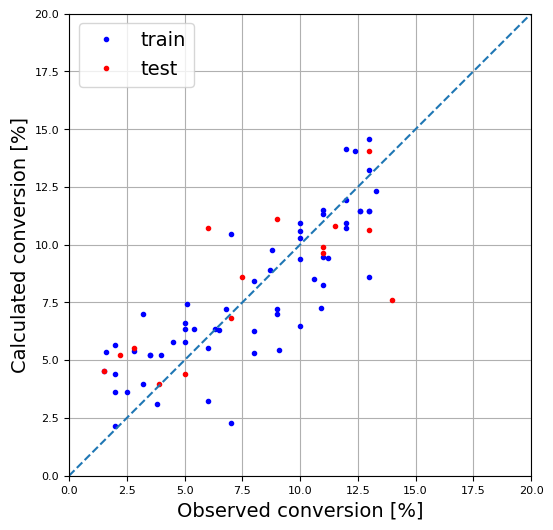

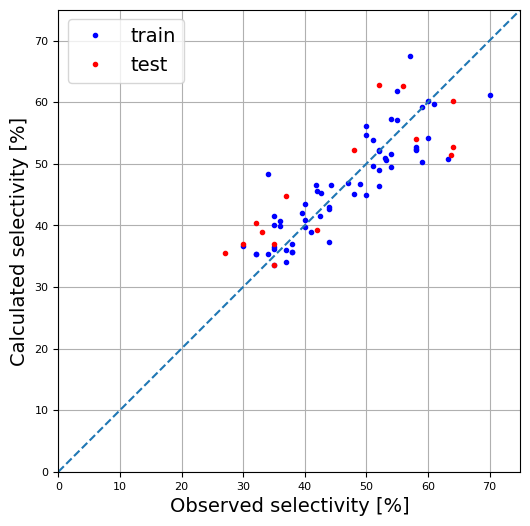

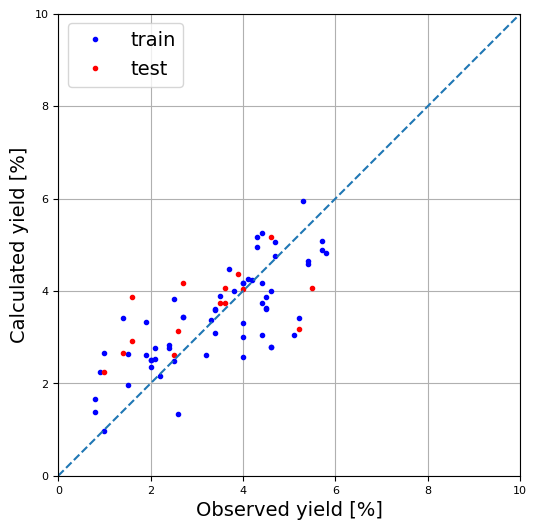


pls original CV_all: 0.335 
train Conv 0.686 Sel 0.749 Yield 0.552 test Conv 0.609 Sel 0.656 Yield 0.305 

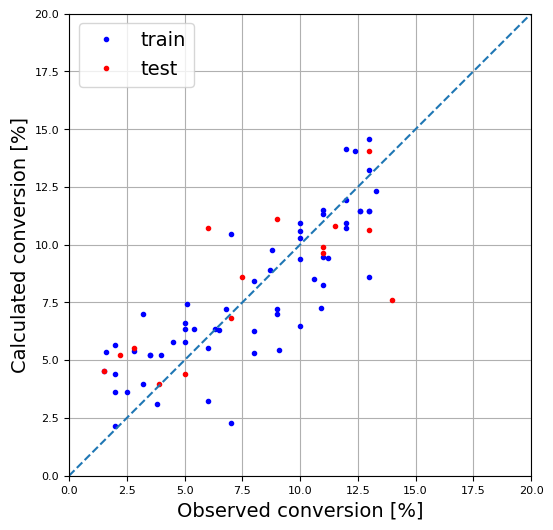

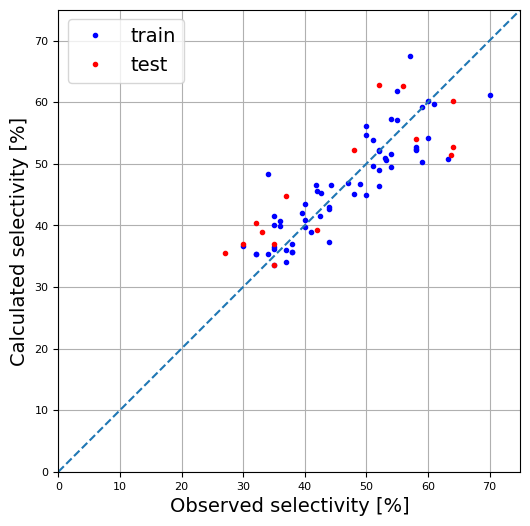

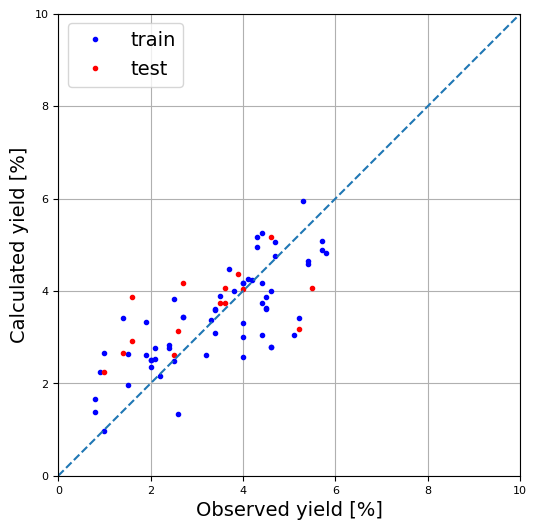


Fitting 5 folds for each of 100 candidates, totalling 500 fits
rf variable CV_all: 0.601 
train Conv 0.963 Sel 0.963 Yield 0.939 test Conv 0.791 Sel 0.866 Yield 0.599 

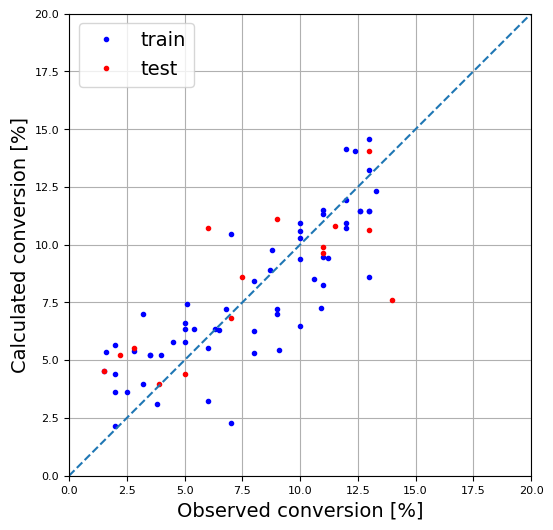

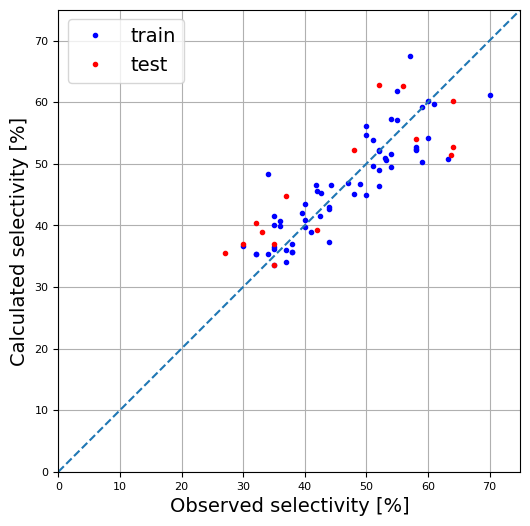

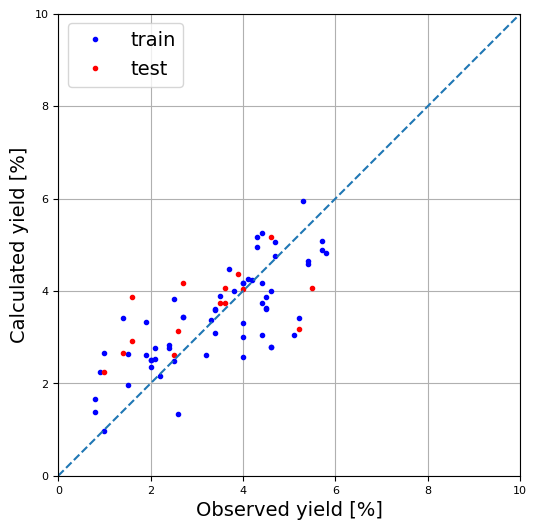


Fitting 5 folds for each of 100 candidates, totalling 500 fits
rf original CV_all: 0.589 
train Conv 1.000 Sel 0.999 Yield 0.999 test Conv 0.787 Sel 0.825 Yield 0.606 

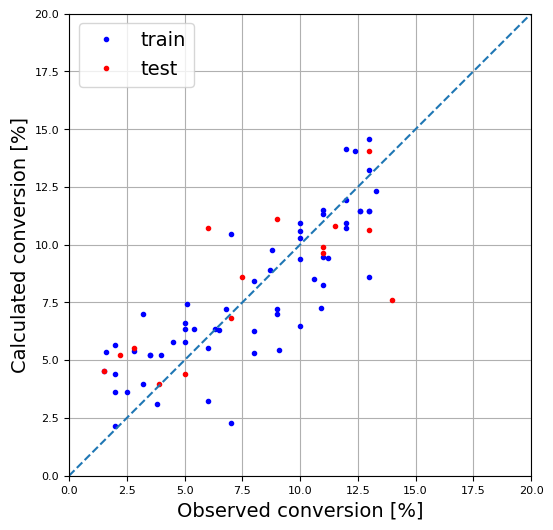

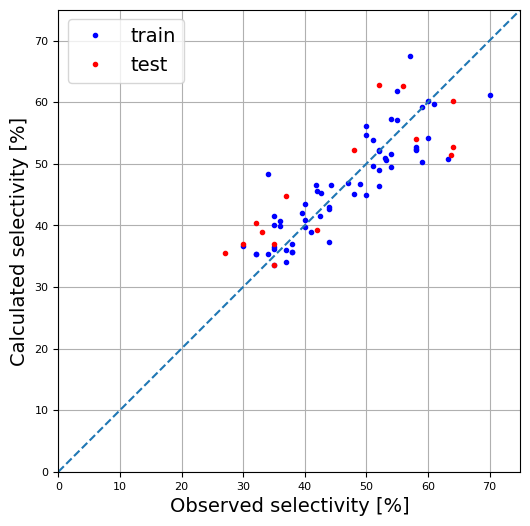

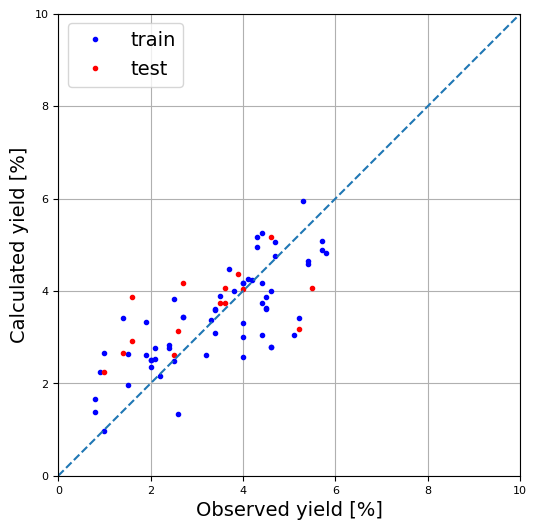

In [42]:
n_folds = 5
models = {}
ycalc =[]
ypred =[]

for model_name, base in zip(['pls', 'rf' ], [PLSRegression(), RandomForestRegressor()]):
    if model_name not in models.keys():
        models[model_name] = {}
        
    for desc_name, vars in zip(['variable', 'original'], [VARIABLE, ORIGINAL]):
        Xtrain = train_data[vars]
        ytrain = train_data[TARGET]
        Xtest = test_data[vars]
        ytest = test_data[TARGET]
        
        if model_name == 'pls':
            pipe = make_pipeline(StandardScaler(), base)
            params={'plsregression__n_components': np.arange(1,11)}
            model = GridSearchCV(pipe, params, cv=n_folds)
            
        elif model_name == 'rf': 
            pipe=base
            model = RandomizedSearchCV(pipe, random_grid, n_iter=100, 
                                       cv=n_folds, verbose=2, random_state=42, n_jobs = -1)
        model.fit(Xtrain, ytrain)
        
        print(model_name, desc_name,'CV_all: %.3f '%model.best_score_)
        
        
        for g_name, Xs, yo, yp in zip(['train','test'], [Xtrain, Xtest], [ytrain, ytest],[ycalc,ypred]):
            y = model.predict(Xs)
            
            yp.append(y)
            
            print(g_name, end=' ')
            
            for i_comp in range(len(TARGET)):
                print(TARGET[i_comp]+' %.3f'%r2_score(yo.iloc[:,i_comp], y[:,i_comp]), end=' ')
                
            
        make_plot(ytrain, ycalc[0], ytest, ypred[0])
        
                
        models[model_name][desc_name] = model 
        print()

### 寄与率を可視化

`feature_importances`を使い、Random forestモデルの解釈を試みてみることにしましょう。

In [43]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.figsize'] = [10, 8]

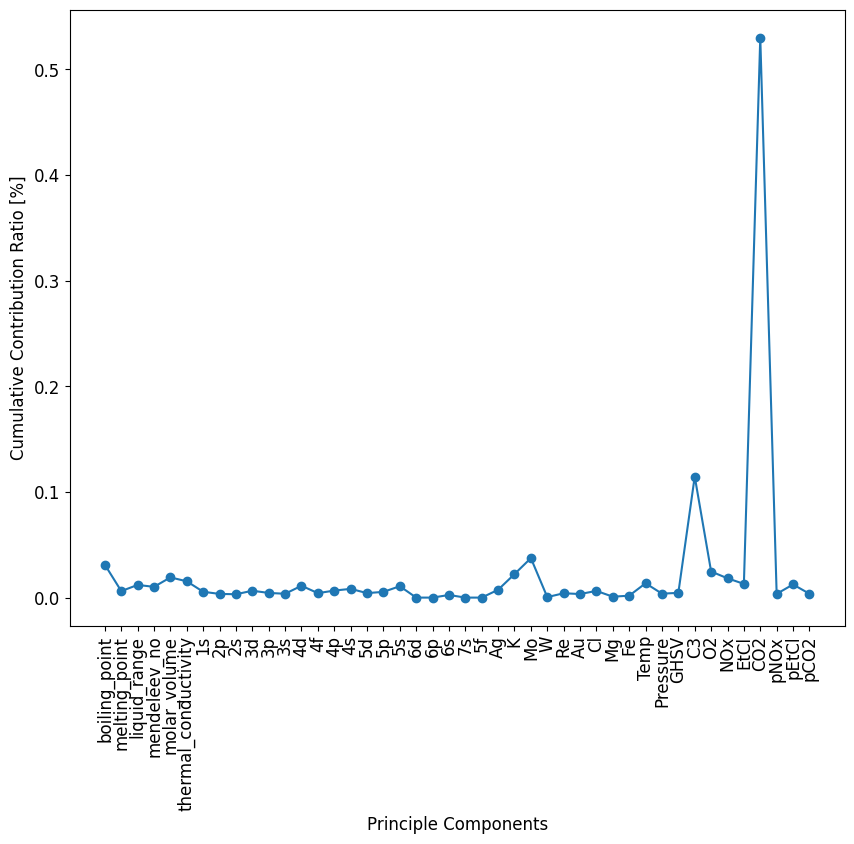

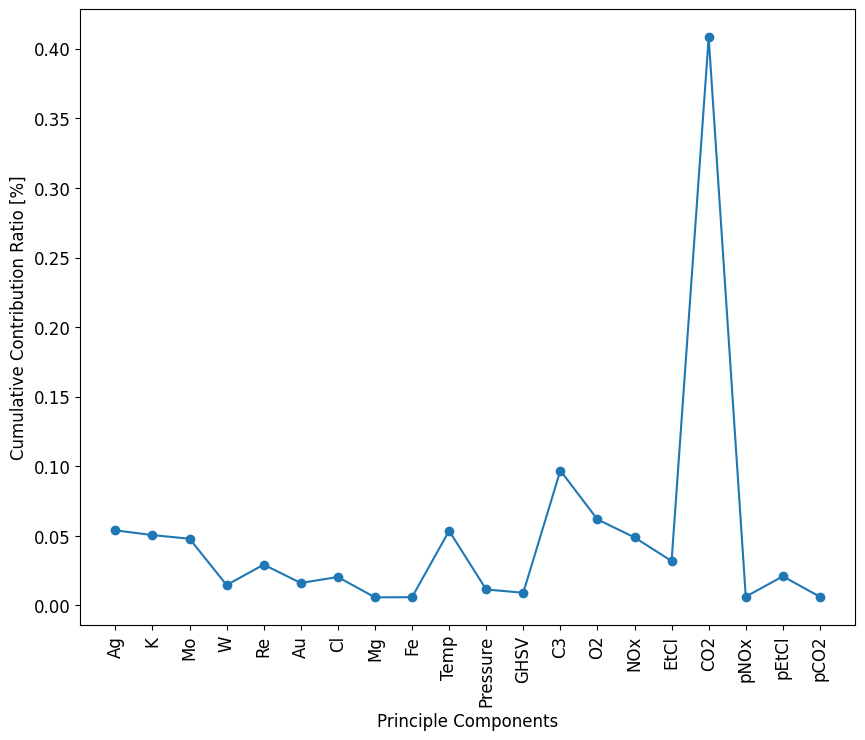

In [44]:
for desc_name, labels_xticks in zip(['variable', 'original'],[VARIABLE, ORIGINAL]): 
    fig, ax= plt.subplots()
    
    ax.plot(models['rf'][desc_name].best_estimator_.feature_importances_, '-o')
    
    plt.xticks(range(len(labels_xticks)))
    ax.set_xticklabels(labels_xticks, rotation=90)
    
    plt.xlabel('Principle Components')
    plt.ylabel('Cumulative Contribution Ratio [%]')
    plt.show()

## 考察の例

- `ORIGINAL`と`VARIABLE`の記述子セットを利用しても精度に差は見られなかった
- PLSとランダムフォレストではランダムフォレストの方が予測精度が高かった。すなわち、目的変数と説明変数の間には非線形性が成り立つ
- [元となる論文](https://www.jstage.jst.go.jp/article/jcac/7/0/7_0_69/_article/-char/ja/)ではPLSと変数選択を組み合わせたGAPLSを用いた解析を行っていたが、精度は低かった
- ランダムフォレストにおいて記述子寄与率を確認すると$CO_2$濃度が重要な変数であることが分かった